In [1]:
import helpers.input_processor as ip

data_dir = 'data/raw_training/training_data'
data_frame = ip.ingest_data(data_dir)

print(data_frame.head())

Ingesting data from  data/raw_training/training_data
shape: (5, 26)
┌──────────┬────────────┬────────────┬───────────┬─────┬────────────┬────────┬────────┬────────────┐
│ patient_ ┆ num_locati ┆ sampling_f ┆ audio_fil ┆ ... ┆ dia_mur_qu ┆ outcom ┆ campai ┆ additional │
│ id       ┆ ons        ┆ requency   ┆ es        ┆     ┆ ality      ┆ e      ┆ gn     ┆ _id        │
│ ---      ┆ ---        ┆ ---        ┆ ---       ┆     ┆ ---        ┆ ---    ┆ ---    ┆ ---        │
│ str      ┆ str        ┆ str        ┆ list[str] ┆     ┆ str        ┆ str    ┆ str    ┆ str        │
╞══════════╪════════════╪════════════╪═══════════╪═════╪════════════╪════════╪════════╪════════════╡
│ 13918    ┆ 4          ┆ 4000       ┆ ["13918_A ┆ ... ┆ nan        ┆ Abnorm ┆ CC2015 ┆ nan        │
│          ┆            ┆            ┆ V.wav",   ┆     ┆            ┆ al     ┆        ┆            │
│          ┆            ┆            ┆ "13918_PV ┆     ┆            ┆        ┆        ┆            │
│          ┆           

In [2]:
import helpers.audio_tools as audio_tools
import tqdm

spectrograms = []

murmur = []

total_audio_files = sum([len(files) for files in data_frame.get_column('audio_files')])

print('Total audio files: {}'.format(total_audio_files))

progress_bar = tqdm.tqdm(total=total_audio_files)
progress_bar.set_description('Audio Files Processed')
progress_bar.n = 0
progress_bar.refresh()


for col in range(len(data_frame.get_column("audio_files"))):
    spectro_array = []
    murmur.append(data_frame.get_column("murmur")[col])
    for row in range(len(data_frame.get_column("audio_files")[col])):
        spectro_array = audio_tools.wav_to_spectro(data_dir + "/" + data_frame.get_column("audio_files")[col][row], sr=4000)
        # output percentage of files processed
        progress_bar.update(1)

    spectrograms.append(spectro_array)


Total audio files: 3163


Audio Files Processed: 100%|██████████| 3163/3163 [00:23<00:00, 146.25it/s]

Absent


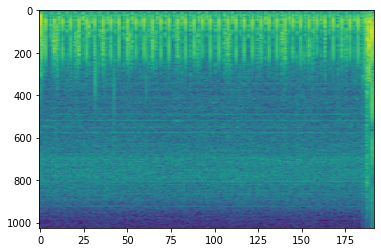

In [3]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(spectrograms))

# display a random spectrogram
plt.imshow(spectrograms[random_index], aspect='auto')
print(murmur[random_index])


In [4]:
murmur_encoded = []
print(set(murmur))

# loop through the set of murmurs and encode them as floats, Absent = 0, Unknown = 0.5, Present = 1
for murm in murmur:
    if murm == 'Absent':
        murmur_encoded.append(0)
    elif murm == 'Unknown':
        murmur_encoded.append(0.5)
    elif murm == 'Present':
        murmur_encoded.append(1)
    else:
        print("Error: Unknown murmur type")

print(len(murmur_encoded))

{'Present', 'Absent', 'Unknown'}
942


In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())



2022-06-10 18:52:10.456986: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17251027722479584645
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31993823232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14560765901167830784
physical_device_desc: "device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2022-06-10 18:52:11.637950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 18:52:12.275688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 30511 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


Audio Files Processed: 100%|██████████| 3163/3163 [00:26<00:00, 117.89it/s]


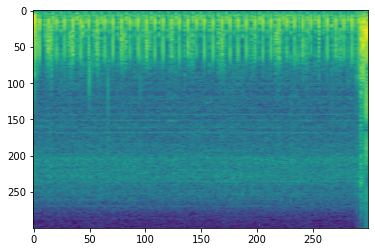

In [6]:
import tensorflow as tf
import skimage.transform as st
import numpy as np

progress_bar = tqdm.tqdm(total=len(spectrograms))
progress_bar.set_description('Spectrograms Processed')
progress_bar.n = 0
progress_bar.refresh()

# loop through the specrograms and resize them to 300x300
for i in range(len(spectrograms)):
    spectrograms[i] = st.resize(spectrograms[i], (300, 300))
    progress_bar.update(1)


plt.imshow(spectrograms[random_index], aspect='auto')


Absent
(300, 300)


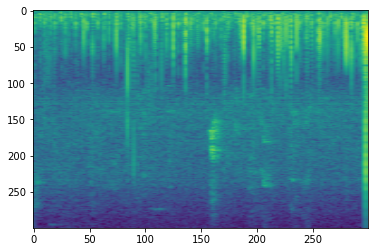

In [7]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(spectrograms))

# display a random spectrogram
plt.imshow(spectrograms[random_index], aspect='auto')
print(murmur[random_index])
print(spectrograms[random_index].shape)

In [8]:
spectrograms = np.array(spectrograms, dtype=np.float32)
murmur_encoded = np.array(murmur_encoded, dtype=np.float32)

print(spectrograms.shape)

(942, 300, 300)


In [9]:
spectrograms = spectrograms.reshape([-1, 300, 300, 1])

In [10]:
print(spectrograms.shape)

(942, 300, 300, 1)


In [11]:
print(spectrograms[random_index])

# normalize the spectrograms between 0 and 1
# get the max and min values of the spectrograms
for i in range(len(spectrograms)):
    spectrograms[i] = (spectrograms[i] - np.min(spectrograms[i])) / (np.max(spectrograms[i]) - np.min(spectrograms[i]))

print(spectrograms[random_index])

[[[ -7.151709]
  [ -6.989136]
  [ -5.688554]
  ...
  [-10.913487]
  [-14.632184]
  [-15.097021]]

 [[-12.176152]
  [-12.094769]
  [-11.443704]
  ...
  [-10.004247]
  [ -9.911595]
  [ -9.900014]]

 [[ -8.608801]
  [ -8.733194]
  [ -9.728341]
  ...
  [-12.823455]
  [ -8.827269]
  [ -8.327745]]

 ...

 [[-40.622   ]
  [-40.48969 ]
  [-39.43121 ]
  ...
  [-25.240559]
  [-26.518097]
  [-26.67779 ]]

 [[-41.530025]
  [-41.481026]
  [-41.089043]
  ...
  [-25.958624]
  [-28.007097]
  [-28.263155]]

 [[-35.54446 ]
  [-35.794678]
  [-37.79641 ]
  ...
  [-27.44167 ]
  [-28.999733]
  [-29.19449 ]]]
[[[0.64067155]
  [0.64283454]
  [0.6601386 ]
  ...
  [0.5906217 ]
  [0.541145  ]
  [0.5349604 ]]

 [[0.57382214]
  [0.5749049 ]
  [0.58356726]
  ...
  [0.602719  ]
  [0.6039517 ]
  [0.60410583]]

 [[0.62128514]
  [0.61963016]
  [0.6063899 ]
  ...
  [0.56520987]
  [0.61837846]
  [0.6250246 ]]

 ...

 [[0.1953545 ]
  [0.19711491]
  [0.21119781]
  ...
  [0.4000022 ]
  [0.38300478]
  [0.3808801 ]]

 [[0.183

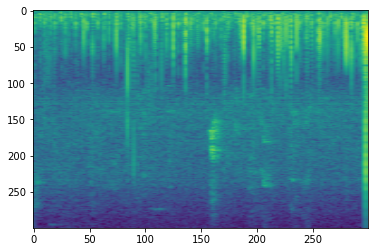

In [12]:
# display a random spectrogram
plt.imshow(spectrograms[random_index], aspect='auto')

In [20]:
%load_ext tensorboard
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input, MaxPooling2D



# create the model
model = Sequential()

# add the input that can take in any image size

model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
from keras.optimizers import Adam
import datetime

# set the optimizer
optimizer = Adam(lr=0.0001)

# binary cross entropy loss function
model.compile(loss='mse' , optimizer=optimizer, metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(spectrograms, murmur_encoded, epochs=20, batch_size=50, validation_split=0.1 , shuffle=True)



/home/andrecox/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
17/17 [==============================] - 3s 138ms/step - loss: 0.0938 - accuracy: 0.8276 - val_loss: 0.1366 - val_accuracy: 0.7263
Epoch 2/20
17/17 [==============================] - 1s 71ms/step - loss: 0.0915 - accuracy: 0.8347 - val_loss: 0.1658 - val_accuracy: 0.6421
Epoch 3/20
17/17 [==============================] - 1s 72ms/step - loss: 0.0907 - accuracy: 0.8335 - val_loss: 0.1514 - val_accuracy: 0.6947
Epoch 4/20
17/17 [==============================] - 1s 71ms/step - loss: 0.0846 - accuracy: 0.8406 - val_loss: 0.1536 - val_accuracy: 0.6737
Epoch 5/20
17/17 [==============================] - 1s 71ms/step - loss: 0.0832 - accuracy: 0.8430 - val_loss: 0.1517 - val_accuracy: 0.6737
Epoch 6/20
17/17 [==============================] - 1s 72ms/step - loss: 0.0831 - accuracy: 0.8406 - val_loss: 0.1436 - val_accuracy: 0.7158
Epoch 7/20
17/17 [==============================] - 1s 76ms/step - loss: 0.0832 - accuracy: 0.8359 - val_loss: 0.1542 - val_accuracy: 0.6737
Epoch 8/20
1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


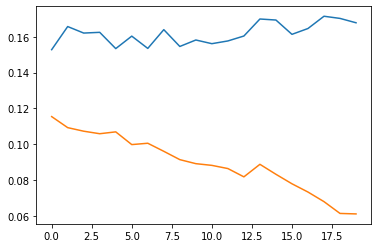

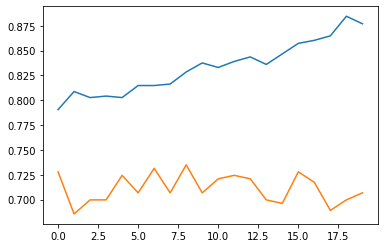

In [26]:
# graph loss over time 
print(history.history.keys())
# plot validation loss
plt.plot(history.history['val_loss'])

# plot training loss
plt.plot(history.history['loss'])
plt.show()

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.show()

In [16]:
# choose a random spectrogram and predict the murmur
random_index = random.randint(0, len(spectrograms))
print(model.predict(spectrograms[random_index].reshape([1, 300, 300, 1])))

print(murmur[random_index])

1/1 [==============================] - 0s 156ms/step
[[0.]]
Unknown


In [17]:
for encoded in murmur_encoded:
    

SyntaxError: unexpected EOF while parsing (3873232969.py, line 2)